In [1]:
using HTTP
using JSON
using DataFrames
using Dates
using TimeSeries

In [2]:
include("../env.jl")

"VVp9vMTjNvSEUqJJuqpRLw5r4oUq2uFGbX2VipCE"

In [3]:
function wgetStock(sym::String)
    fromTime =  Dates.format(now()-Day(500), "yyyy-mm-ddTHH:MM:SS")
    @show fromTime
    headers = ["APCA-API-KEY-ID" => ENV["APCA-API-KEY-ID"], "APCA-API-SECRET-KEY" => ENV["APCA-API-SECRET-KEY"] ]
    url_query = "https://data.alpaca.markets/v1/bars/day?symbols="*sym*"&after="*fromTime*"&limit=500"
    raw_response = HTTP.request("GET", url_query, headers)
    rsp = JSON.parse(String(raw_response.body))
    df2 = DataFrame(t = Int[],h = Float32[],l = Float32[],o = Float32[],c = Float32[],v = Float32[] )
    for (sym,v) in rsp
        for q in v
            push!(df2,q)
        end
    end
    transform!(df2, :t => ( x -> Dates.unix2datetime.(x) ) => :ondate)
    DataFrames.rename!(df2,:h => :High)
    DataFrames.rename!(df2,:l => :Low)
    DataFrames.rename!(df2,:o => :Open)
    DataFrames.rename!(df2,:c => :Close)
    DataFrames.rename!(df2,:v => :Volume)
    sort!(df2,order(:ondate))
    return select(df2,[:Open,:Close,:High,:Low,:Volume,:ondate])
end

wgetStock (generic function with 1 method)

In [4]:
tick1="GLD"
df1 = wgetStock(tick1)
tick2="IAU"
df2 = wgetStock(tick2)

fromTime = "2020-01-31T21:18:07"
fromTime = "2020-01-31T21:18:12"


,Open,Close,High,Low,Volume,ondate
,Float32,Float32,Float32,Float32,Float32,DateTime
1,12.86,12.965,12.98,12.32,2.38345e7,2019-06-19T04:00:00
2,13.22,13.295,13.34,12.405,2.45128e7,2019-06-20T04:00:00
3,13.37,13.39,13.405,13.29,1.66859e7,2019-06-21T04:00:00
4,13.47,13.58,13.59,13.44,2.22944e7,2019-06-24T04:00:00
5,13.69,13.61,13.75,12.86,5.52916e7,2019-06-25T04:00:00
6,13.5,13.48,13.55,13.43,1.58035e7,2019-06-26T04:00:00
7,13.43,13.48,13.49,13.41,1.53106e7,2019-06-27T04:00:00
8,13.49,13.505,13.53,13.45,8.48827e6,2019-06-28T04:00:00
9,13.35,13.25,13.36,13.24,2.35873e7,2019-07-01T04:00:00


In [5]:
using Pkg 
Pkg.add("StatsBase")
using StatsBase
Pkg.add("HypothesisTests")
using HypothesisTests

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:

using Plots
function testStationary(df)
    y = autocor(df,1:20)
    display(bar(y))
    y = pacf(df,1:20)
    display(bar(y))
    ADFTest(df,:none,1)
end

testStationary (generic function with 1 method)

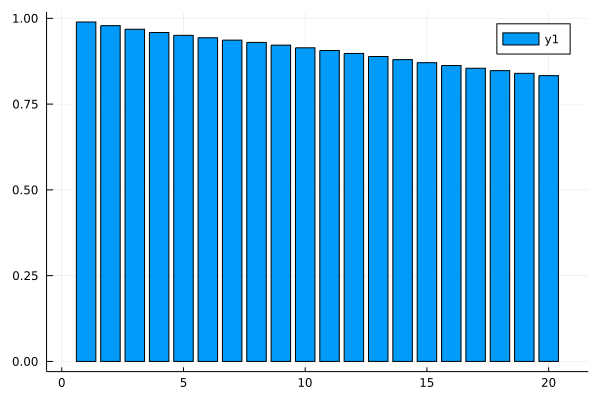

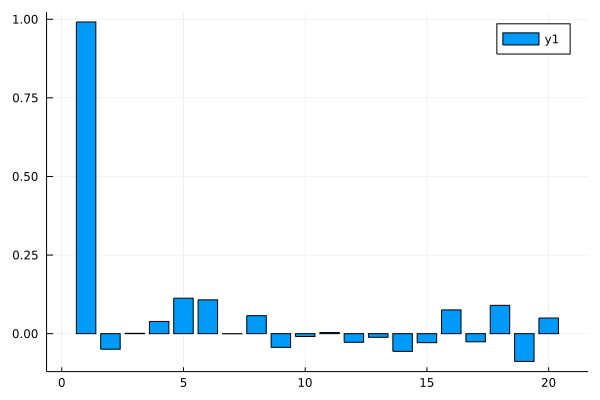

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          0.0004429

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9034

Details:
    sample size in regression:          498
    number of lags:                     1
    ADF statistic:                      0.913552
    Critical values at 1%, 5%, and 10%: [-2.57023 -1.94155 -1.6163]


In [7]:
testStationary(df1[!,:Close])

In [8]:
Pkg.add("TimeSeries")
using TimeSeries

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [9]:
ta1 = TimeArray(df1;timestamp = :ondate)
ta2 = TimeArray(df2;timestamp = :ondate)
merge(ta1[:Close],ta2[:Close],colnames = [:Close1,:Close2])

500×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-06-19T04:00:00 to 2021-06-11T04:00:00
│                     │ Close1 │ Close2 │
├─────────────────────┼────────┼────────┤
│ 2019-06-19T04:00:00 │ 127.89 │ 12.965 │
│ 2019-06-20T04:00:00 │ 131.12 │ 13.295 │
│ 2019-06-21T04:00:00 │ 132.0  │ 13.39  │
│ 2019-06-24T04:00:00 │ 133.94 │ 13.58  │
│ 2019-06-25T04:00:00 │ 134.2  │ 13.61  │
│ 2019-06-26T04:00:00 │ 132.97 │ 13.48  │
│ 2019-06-27T04:00:00 │ 132.84 │ 13.48  │
│ 2019-06-28T04:00:00 │ 133.17 │ 13.505 │
│ 2019-07-01T04:00:00 │ 130.6  │ 13.25  │
│ 2019-07-02T04:00:00 │ 133.38 │ 13.53  │
│ 2019-07-03T04:00:00 │ 133.64 │ 13.56  │
│ 2019-07-05T04:00:00 │ 132.16 │ 13.4   │
   ⋮
│ 2021-05-27T04:00:00 │ 177.78 │ 36.16  │
│ 2021-05-28T04:00:00 │ 178.31 │ 36.26  │
│ 2021-06-01T04:00:00 │ 177.93 │ 36.2   │
│ 2021-06-02T04:00:00 │ 178.75 │ 36.37  │
│ 2021-06-03T04:00:00 │ 175.25 │ 35.645 │
│ 2021-06-04T04:00:00 │ 177.17 │ 36.04  │
│ 2021-06-07T04:00:00 │ 177.88 │ 36.185 │
│ 2021-06-08T04

In [10]:
pct1 = percentchange(ta1[:Close])
pct2 = percentchange(ta2[:Close])
pct = merge(pct1,pct2)
TimeSeries.rename!(pct,:Close => :Close1)
TimeSeries.rename!(pct,:Close_1 => :Close2)
dif = TimeSeries.rename(pct[:Close1] .- pct[:Close2], :Close1_Close2 => :Diff) 
data = merge(pct,dif)
df = DataFrame(data[3:9])
current = DataFrame(data[10])
@show df[3,:Close1]
@show size(current)
current[1,:Close1]

df[3, :Close1] = -0.009165464f0
size(current) = (1, 4)


0.0019493004f0

mean(df[!, :Diff]) = -7.980556f-6
std(df[!, :Diff]) = 0.00044776266f0


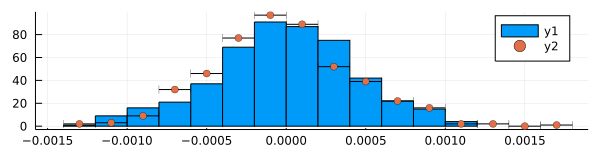

In [21]:
using Random, Distributions
using StatsBase
df = DataFrame(data)

lower = quantile(df[:,:Diff], 0.01)
upper = quantile(df[:,:Diff], 0.99)
df = filter(:Diff => x -> x > lower, df)
df = filter(:Diff => x -> x < upper, df)
@show mean(df[!,:Diff])
@show std(df[!,:Diff])
histogram(df[!,:Diff])
d=fit(Normal, df[!,:Diff])
n = length(df[:,:Diff])
plot!(rand(d, n), seriestype=:scatterhist, linestyle=:solid, size=(600,150))


In [22]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

mean(rand(d, 10000)) = -8.080355606091008e-7
std(rand(d, 10000)) = 0.00044505725899789166


0.00044505725899789166

In [13]:
@show mean(rand(d,10000))
@show std(rand(d,10000))

,timestamp,Close1,Close2,Diff
,DateTime,Float32,Float32,Float32
1,2019-06-20T04:00:00,0.0252561,0.0254531,-0.000197038
2,2019-06-21T04:00:00,0.00671149,0.00714554,-0.000434048
3,2019-06-24T04:00:00,0.0146967,0.0141898,0.000506943
4,2019-06-25T04:00:00,0.00194118,0.002209,-0.000267822
5,2019-06-26T04:00:00,-0.00916546,-0.00955187,0.000386403
6,2019-06-27T04:00:00,-0.000977515,0.0,-0.000977515
7,2019-06-28T04:00:00,0.00248406,0.00185471,0.000629357
8,2019-07-01T04:00:00,-0.0192983,-0.018882,-0.000416283
9,2019-07-02T04:00:00,0.0212862,0.0211321,0.000154119


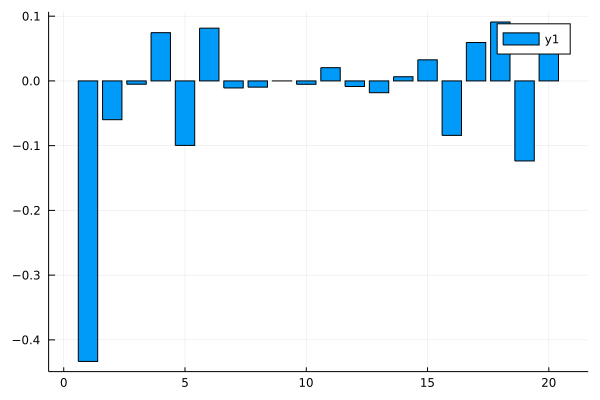

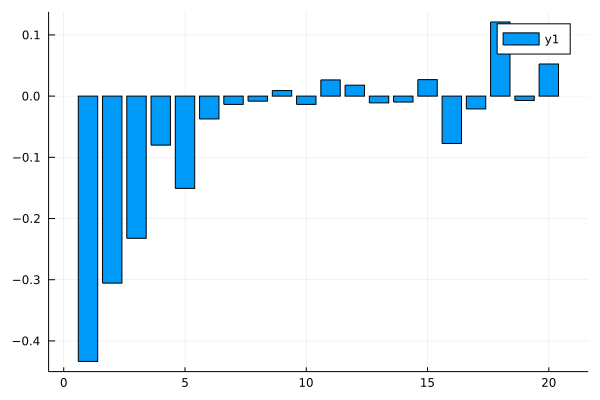

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.87051

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          487
    number of lags:                     1
    ADF statistic:                      -25.5943
    Critical values at 1%, 5%, and 10%: [-2.57033 -1.94156 -1.61629]


In [23]:
testStationary(df[!,:Diff])

In [24]:
# Import Turing and Distributions.
using Turing, Distributions



# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
using MLDataUtils: rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

In [66]:
# Bayesian logistic regression (LR)
@model linearPair(y0,y1,n) = begin
    u ~ Normal(1,0.1)
    for i = 1:n
        y1[i] ~ Normal( u*y0[i],0.1)
    end
end;

In [67]:

n,_ = size(df)
@show n
train = Matrix(df)


n = 489


489×4 Matrix{Any}:
 2019-06-20T04:00:00   0.0252561     0.0254531    -0.000197038
 2019-06-21T04:00:00   0.00671149    0.00714554   -0.000434048
 2019-06-24T04:00:00   0.0146967     0.0141898     0.000506943
 2019-06-25T04:00:00   0.00194118    0.002209     -0.000267822
 2019-06-26T04:00:00  -0.00916546   -0.00955187    0.000386403
 2019-06-27T04:00:00  -0.000977515   0.0          -0.000977515
 2019-06-28T04:00:00   0.00248406    0.00185471    0.000629357
 2019-07-01T04:00:00  -0.0192983    -0.018882     -0.000416283
 2019-07-02T04:00:00   0.0212862     0.0211321     0.000154119
 2019-07-03T04:00:00   0.0019493     0.00221736   -0.000268063
 2019-07-05T04:00:00  -0.0110747    -0.0117995     0.000724752
 2019-07-08T04:00:00  -0.00658291   -0.00597023   -0.000612681
 2019-07-09T04:00:00   0.00373248    0.0033786     0.000353875
 ⋮                                                            
 2021-05-26T04:00:00  -0.0016861    -0.00179559    0.000109482
 2021-05-27T04:00:00   0.000844358  

In [68]:



# Sample using HMC.
chain = mapreduce(c -> sample(linearPair(train[:,2],train[:,3],n),NUTS(200, 0.65), 1000, discard_adapt=true),
    chainscat,
    1:5
)

describe(chain)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2015625
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kahingleung/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
Sampling: 100%|█

2-element Vector{ChainDataFrame}:
 Summary Statistics (1 x 8)
 Quantiles (1 x 6)

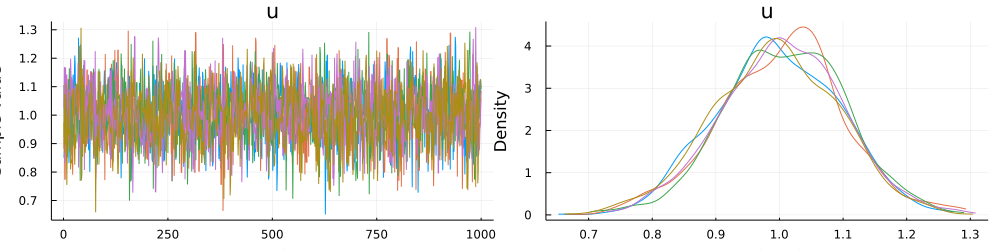

In [69]:
plot(chain)

In [70]:
chain

Chains MCMC chain (1000×13×5 Array{Float64, 3}):

Start time        = 2021-06-14T13:57:45.106
Stop time         = 2021-06-14T13:57:49.376
Wall duration     = 4.27 seconds
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5
Samples per chain = 1000
parameters        = u
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           u    1.0017    0.0964     0.0014    0.0022   2449.0395    1.0033    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          

In [79]:
lookback = 12
for (row_index,row) in enumerate(eachrow(pct))
    @show row.timestamp
    @show row.Close1
    @show row.Close2
    @show row_index
    if row_index >= lookback
        i = row_index
        @show pct[i-lookback+1:i]
    end
    
end

row.timestamp = DateTime("2019-06-20T04:00:00")
row.Close1 = 0.025256062f0
row.Close2 = 0.0254531f0
row_index = 1
row.timestamp = DateTime("2019-06-21T04:00:00")
row.Close1 = 0.0067114932f0
row.Close2 = 0.007145541f0
row_index = 2
row.timestamp = DateTime("2019-06-24T04:00:00")
row.Close1 = 0.014696737f0
row.Close2 = 0.014189794f0
row_index = 3
row.timestamp = DateTime("2019-06-25T04:00:00")
row.Close1 = 0.0019411783f0
row.Close2 = 0.0022090003f0
row_index = 4
row.timestamp = DateTime("2019-06-26T04:00:00")
row.Close1 = -0.009165464f0
row.Close2 = -0.009551867f0
row_index = 5
row.timestamp = DateTime("2019-06-27T04:00:00")
row.Close1 = -0.0009775149f0
row.Close2 = 0.0f0
row_index = 6
row.timestamp = DateTime("2019-06-28T04:00:00")
row.Close1 = 0.0024840639f0
row.Close2 = 0.001854707f0
row_index = 7
row.timestamp = DateTime("2019-07-01T04:00:00")
row.Close1 = -0.019298261f0
row.Close2 = -0.018881978f0
row_index = 8
row.timestamp = DateTime("2019-07-02T04:00:00")
row.Close1 = 0.021286238

row.Close2 = -0.023521474f0
row_index = 54
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-20T04:00:00 to 2019-09-05T04:00:00
row.timestamp = DateTime("2019-09-06T04:00:00")
row.Close1 = -0.008592197f0
row.Close2 = -0.0089469245f0
row_index = 55
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-21T04:00:00 to 2019-09-06T04:00:00
row.timestamp = DateTime("2019-09-09T04:00:00")
row.Close1 = -0.0037347495f0
row.Close2 = -0.0038195436f0
row_index = 56
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-22T04:00:00 to 2019-09-09T04:00:00
row.timestamp = DateTime("2019-09-10T04:00:00")
row.Close1 = -0.00869903f0
row.Close2 = -0.008713683f0
row_index = 57
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-08-23T04:00:00 to 2019-09-10T04:00:00
row.timestamp = DateTime("2019-09-11T04:00:00")
row.Close1 = 0.006135613f0
row.Close2 = 0.00632897

row.Close2 = -0.0024196391f0
row_index = 96
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-18T04:00:00 to 2019-11-04T05:00:00
row.timestamp = DateTime("2019-11-05T05:00:00")
row.Close1 = -0.015828365f0
row.Close2 = -0.016632164f0
row_index = 97
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-21T04:00:00 to 2019-11-05T05:00:00
row.timestamp = DateTime("2019-11-06T05:00:00")
row.Close1 = 0.0040742676f0
row.Close2 = 0.004580945f0
row_index = 98
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-22T04:00:00 to 2019-11-06T05:00:00
row.timestamp = DateTime("2019-11-07T05:00:00")
row.Close1 = -0.015590406f0
row.Close2 = -0.015082616f0
row_index = 99
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2019-10-23T04:00:00 to 2019-11-07T05:00:00
row.timestamp = DateTime("2019-11-08T05:00:00")
row.Close1 = -0.006436525f0
row.Close2 = -0.00641023

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-22T05:00:00 to 2020-02-06T05:00:00
row.timestamp = DateTime("2020-02-07T05:00:00")
row.Close1 = 0.0024419988f0
row.Close2 = 0.0023387559f0
row_index = 161
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-23T05:00:00 to 2020-02-07T05:00:00
row.timestamp = DateTime("2020-02-10T05:00:00")
row.Close1 = 0.0025715458f0
row.Close2 = 0.0026666848f0
row_index = 162
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-24T05:00:00 to 2020-02-10T05:00:00
row.timestamp = DateTime("2020-02-11T05:00:00")
row.Close1 = -0.0032400931f0
row.Close2 = -0.0039893473f0
row_index = 163
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-01-27T05:00:00 to 2020-02-11T05:00:00
row.timestamp = DateTime("2020-02-12T05:00:00")
row.Close1 = -0.0009479795f0
row.Close2 = -0.0003337303f0
row_index = 164
pct[(i - lookbac

pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-23T04:00:00 to 2020-04-07T04:00:00
row.timestamp = DateTime("2020-04-08T04:00:00")
row.Close1 = -0.008971734f0
row.Close2 = -0.010088234f0
row_index = 203
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-24T04:00:00 to 2020-04-08T04:00:00
row.timestamp = DateTime("2020-04-09T04:00:00")
row.Close1 = 0.02547706f0
row.Close2 = 0.025477793f0
row_index = 204
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-25T04:00:00 to 2020-04-09T04:00:00
row.timestamp = DateTime("2020-04-13T04:00:00")
row.Close1 = 0.017844668f0
row.Close2 = 0.019875681f0
row_index = 205
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-03-26T04:00:00 to 2020-04-13T04:00:00
row.timestamp = DateTime("2020-04-14T04:00:00")
row.Close1 = 0.007681636f0
row.Close2 = 0.006090277f0
row_index = 206
pct[(i - lookback) + 1:i] =

row.Close2 = 0.0066997325f0
row_index = 265
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-22T04:00:00 to 2020-07-08T04:00:00
row.timestamp = DateTime("2020-07-09T04:00:00")
row.Close1 = -0.0027637368f0
row.Close2 = -0.002893545f0
row_index = 266
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-23T04:00:00 to 2020-07-09T04:00:00
row.timestamp = DateTime("2020-07-10T04:00:00")
row.Close1 = -0.0025354612f0
row.Close2 = -0.0029018654f0
row_index = 267
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-24T04:00:00 to 2020-07-10T04:00:00
row.timestamp = DateTime("2020-07-13T04:00:00")
row.Close1 = 0.0011527024f0
row.Close2 = 0.0017460313f0
row_index = 268
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-06-25T04:00:00 to 2020-07-13T04:00:00
row.timestamp = DateTime("2020-07-14T04:00:00")
row.Close1 = 0.004812339f0
row.Close2 = 0.004

row.Close1 = 0.0029258532f0
row.Close2 = 0.003260911f0
row_index = 307
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-20T04:00:00 to 2020-09-04T04:00:00
row.timestamp = DateTime("2020-09-08T04:00:00")
row.Close1 = -0.0019264715f0
row.Close2 = -0.0016251695f0
row_index = 308
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-21T04:00:00 to 2020-09-08T04:00:00
row.timestamp = DateTime("2020-09-09T04:00:00")
row.Close1 = 0.009375861f0
row.Close2 = 0.009224019f0
row_index = 309
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-24T04:00:00 to 2020-09-09T04:00:00
row.timestamp = DateTime("2020-09-10T04:00:00")
row.Close1 = -0.0032785912f0
row.Close2 = -0.0037632526f0
row_index = 310
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-08-25T04:00:00 to 2020-09-10T04:00:00
row.timestamp = DateTime("2020-09-11T04:00:00")
row.Close1 = 0.0f0


row.Close1 = -0.0028355375f0
row.Close2 = -0.0028471868f0
row_index = 370
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-18T05:00:00 to 2020-12-04T05:00:00
row.timestamp = DateTime("2020-12-07T05:00:00")
row.Close1 = 0.014798833f0
row.Close2 = 0.015419617f0
row_index = 371
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-19T05:00:00 to 2020-12-07T05:00:00
row.timestamp = DateTime("2020-12-08T05:00:00")
row.Close1 = 0.0036602085f0
row.Close2 = 0.0030934876f0
row_index = 372
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-20T05:00:00 to 2020-12-08T05:00:00
row.timestamp = DateTime("2020-12-09T05:00:00")
row.Close1 = -0.0173505f0
row.Close2 = -0.017101193f0
row_index = 373
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2020-11-23T05:00:00 to 2020-12-09T05:00:00
row.timestamp = DateTime("2020-12-10T05:00:00")
row.Close1 = -0.001536

row.timestamp = DateTime("2021-02-05T05:00:00")
row.Close1 = 0.009992123f0
row.Close2 = 0.009362143f0
row_index = 412
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-21T05:00:00 to 2021-02-05T05:00:00
row.timestamp = DateTime("2021-02-08T05:00:00")
row.Close1 = 0.00995215f0
row.Close2 = 0.011014599f0
row_index = 413
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-22T05:00:00 to 2021-02-08T05:00:00
row.timestamp = DateTime("2021-02-09T05:00:00")
row.Close1 = 0.0034984606f0
row.Close2 = 0.0033714257f0
row_index = 414
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-25T05:00:00 to 2021-02-09T05:00:00
row.timestamp = DateTime("2021-02-10T05:00:00")
row.Close1 = 0.003719076f0
row.Close2 = 0.0034972643f0
row_index = 415
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-01-26T05:00:00 to 2021-02-10T05:00:00
row.timestamp = DateTime("

row.timestamp = DateTime("2021-05-12T04:00:00")
row.Close1 = -0.009990992f0
row.Close2 = -0.0102798585f0
row_index = 478
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-27T04:00:00 to 2021-05-12T04:00:00
row.timestamp = DateTime("2021-05-13T04:00:00")
row.Close1 = 0.004165719f0
row.Close2 = 0.004039078f0
row_index = 479
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-28T04:00:00 to 2021-05-13T04:00:00
row.timestamp = DateTime("2021-05-14T04:00:00")
row.Close1 = 0.008998586f0
row.Close2 = 0.009770129f0
row_index = 480
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-29T04:00:00 to 2021-05-14T04:00:00
row.timestamp = DateTime("2021-05-17T04:00:00")
row.Close1 = 0.0118137365f0
row.Close2 = 0.01186681f0
row_index = 481
pct[(i - lookback) + 1:i] = 12×2 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-04-30T04:00:00 to 2021-05-17T04:00:00
row.timestamp = DateTime(

In [17]:
N = length(pct)

499

In [71]:
for i in 2:N
    @show values(pct[i-1:i,:Close1])
end

values(pct[i - 1:i, :Close1]) = Float32[0.025256062; 0.0067114932]
values(pct[i - 1:i, :Close1]) = Float32[0.0067114932; 0.014696737]
values(pct[i - 1:i, :Close1]) = Float32[0.014696737; 0.0019411783]
values(pct[i - 1:i, :Close1]) = Float32[0.0019411783; -0.009165464]
values(pct[i - 1:i, :Close1]) = Float32[-0.009165464; -0.0009775149]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009775149; 0.0024840639]
values(pct[i - 1:i, :Close1]) = Float32[0.0024840639; -0.019298261]
values(pct[i - 1:i, :Close1]) = Float32[-0.019298261; 0.021286238]
values(pct[i - 1:i, :Close1]) = Float32[0.021286238; 0.0019493004]
values(pct[i - 1:i, :Close1]) = Float32[0.0019493004; -0.01107475]
values(pct[i - 1:i, :Close1]) = Float32[-0.01107475; -0.006582909]
values(pct[i - 1:i, :Close1]) = Float32[-0.006582909; 0.003732477]
values(pct[i - 1:i, :Close1]) = Float32[0.003732477; 0.015480384]
values(pct[i - 1:i, :Close1]) = Float32[0.015480384; -0.008369511]
values(pct[i - 1:i, :Close1]) = Float32[-0.008369511; 0.0

values(pct[i - 1:i, :Close1]) = Float32[0.006892964; -0.0087255]
values(pct[i - 1:i, :Close1]) = Float32[-0.0087255; 0.005281518]
values(pct[i - 1:i, :Close1]) = Float32[0.005281518; -0.0001349358]
values(pct[i - 1:i, :Close1]) = Float32[-0.0001349358; 0.0061975047]
values(pct[i - 1:i, :Close1]) = Float32[0.0061975047; -0.006694695]
values(pct[i - 1:i, :Close1]) = Float32[-0.006694695; -0.013210006]
values(pct[i - 1:i, :Close1]) = Float32[-0.013210006; 0.0010925535]
values(pct[i - 1:i, :Close1]) = Float32[0.0010925535; 0.0057312544]
values(pct[i - 1:i, :Close1]) = Float32[0.0057312544; 0.0024419988]
values(pct[i - 1:i, :Close1]) = Float32[0.0024419988; 0.0025715458]
values(pct[i - 1:i, :Close1]) = Float32[0.0025715458; -0.0032400931]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032400931; -0.0009479795]
values(pct[i - 1:i, :Close1]) = Float32[-0.0009479795; 0.0056938487]
values(pct[i - 1:i, :Close1]) = Float32[0.0056938487; 0.0041111344]
values(pct[i - 1:i, :Close1]) = Float32[0.0041111

values(pct[i - 1:i, :Close1]) = Float32[-0.012918229; -0.008104209]
values(pct[i - 1:i, :Close1]) = Float32[-0.008104209; 0.0029258532]
values(pct[i - 1:i, :Close1]) = Float32[0.0029258532; -0.0019264715]
values(pct[i - 1:i, :Close1]) = Float32[-0.0019264715; 0.009375861]
values(pct[i - 1:i, :Close1]) = Float32[0.009375861; -0.0032785912]
values(pct[i - 1:i, :Close1]) = Float32[-0.0032785912; 0.0]
values(pct[i - 1:i, :Close1]) = Float32[0.0; 0.00789404]
values(pct[i - 1:i, :Close1]) = Float32[0.00789404; -0.0021211032]
values(pct[i - 1:i, :Close1]) = Float32[-0.0021211032; 0.0026160066]
values(pct[i - 1:i, :Close1]) = Float32[0.0026160066; -0.0053277635]
values(pct[i - 1:i, :Close1]) = Float32[-0.0053277635; 0.0010935082]
values(pct[i - 1:i, :Close1]) = Float32[0.0010935082; -0.020090584]
values(pct[i - 1:i, :Close1]) = Float32[-0.020090584; -0.004791664]
values(pct[i - 1:i, :Close1]) = Float32[-0.004791664; -0.021496952]
values(pct[i - 1:i, :Close1]) = Float32[-0.021496952; 0.00366164

values(pct[i - 1:i, :Close1]) = Float32[-0.0060019847; 0.0070240465]
values(pct[i - 1:i, :Close1]) = Float32[0.0070240465; -0.0044053034]
values(pct[i - 1:i, :Close1]) = Float32[-0.0044053034; 0.016039811]
values(pct[i - 1:i, :Close1]) = Float32[0.016039811; 0.0062905885]
values(pct[i - 1:i, :Close1]) = Float32[0.0062905885; -0.0028250767]
values(pct[i - 1:i, :Close1]) = Float32[-0.0028250767; 0.0035563617]
values(pct[i - 1:i, :Close1]) = Float32[0.0035563617; 0.009850542]
values(pct[i - 1:i, :Close1]) = Float32[0.009850542; -0.006423733]
values(pct[i - 1:i, :Close1]) = Float32[-0.006423733; -0.0039508766]
values(pct[i - 1:i, :Close1]) = Float32[-0.0039508766; 0.0027044562]
values(pct[i - 1:i, :Close1]) = Float32[0.0027044562; -0.0025173873]
values(pct[i - 1:i, :Close1]) = Float32[-0.0025173873; 0.0030645502]
values(pct[i - 1:i, :Close1]) = Float32[0.0030645502; -0.0040140436]
values(pct[i - 1:i, :Close1]) = Float32[-0.0040140436; -0.0035485101]
values(pct[i - 1:i, :Close1]) = Float32[

In [19]:

function BuyOrSell(data)
    lookback,_ = size(data)
    df = DataFrame(data[1:lookback-1])
    current = DataFrame(data[lookback])
    
    mean1 = 
    std1 =  
    mean12 = 
    std12 = 
    mean2 = 
    std2 = 
    p1 = current[1,:Close1]
    p2 = current[1,:Close2]
    dif12 = current[1,:Diff]

    act1 = 0
    act2 = 0
    thd2 = 2
    thd1 = 1
    
    if p1 >= mean1 + thd2*std1
        act1 = -1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
                if dif12 > mean12 + thd1*std12
                    act2 = 1
                elseif dif12 < mean12 - thd1*std12
                    act2 = -1
                end    
        else
            act2 = 1
        end
    elseif p1 > mean1 - thd2*std1
        if p2 >= mean2 + thd2*std2
            act2 = -1
            if dif12 > mean12 + thd1*std12
                    act1 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = -1
            end  
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act1 = -1
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
                    act2 = -1
            end        
        else
            act2 = 1
            if dif12 > mean12 + thd1*std12
                    act1 = -1
            elseif dif12 < mean12 - thd1*std12
                    act1 = 1
            end     
        end
    else
        act1 = 1
        if p2 >= mean2 + thd2*std2
            act2 = -1
        elseif p2 > mean2 - thd2*std2
            if dif12 > mean12 + thd1*std12
                    act2 = 1
            elseif dif12 < mean12 - thd1*std12
                    act2 = -1
            end       
        else
            act2 = 1
        end
    end
    return (act1,act2)
end

BuyOrSell (generic function with 1 method)

In [20]:
[i-2+1:i for i in 1:2]

2-element Vector{UnitRange{Int64}}:
 0:1
 1:2